[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/floleuerer/ml-tutorials/blob/main/01_fastai_pets.ipynb)

# Überblick
Für dieses Tutorial nutzen wir Fastai - eine Open Source Deep Learning Library in Python. Diesen Code können wir im Browser mit Hilfe von Google Colab auführen. Dafür ist keine Kofiguration eforderlich und es kann kostenlos auf GPUs zugegriffen werden. Der Code und Text wird dabei in sogenannten Dokumenten geschrieben. Dies sind Jupyter Notebooks. Sie bieten doe Möglichkeit Modelle zu trainieren und mit ihnen zu experimentieren. Ein Modell ist eine Datei die darauf trainiert wurde, bestimmte Arten von Mustern zu erkennen. Es zeigt, was ein Machine Learning Algorithmus gelernt hat.
In diesem Abschnitt werden wir ein pretrained Modell nutzen, um Katzen und Hunde zu unterscheiden.

# Vorbereitungen in Colab

Wenn du ein Notebook in Google Colab öffnest, musst du den "Laufzeit-Typen" den Instanz auf "GPU" ändern. Damit bekommst die Instanz eine GPU zugewiesen und das Training ist deutlich schneller. 

Menü "Laufzeit" -> "Laufzeittyp ändern"

<div>
<img src="imgs/01_runtime_type.png" width="600">
</div>

Im Pop-Up den Hardwarebeschleuniger auf "GPU" ändern und "Speichern".

<div>
<img src="imgs/02_runtime_type_gpu.png" width="400">
</div>

Die Instanz wird jetzt neu geladen und du musst alle Zellen noch einmal ausführen!

# Pakete installieren und importieren

Python-Pakete von [fast.ai](https://www.fast.ai) installieren und importieren.

In [2]:
!pip install -Uq fastai

In [3]:
from fastai.vision.all import *

**Wichtig!** Wenn die folgende Zelle "False" ausgibt, ist keine GPU vorhanden -> Bitte prüfe die o. g. Schritte noch einmal und starte ggf. das Notebook neu. Bei "True" hast du eine GPU-Instanz und kannst weiter machen.

In [4]:
torch.cuda.is_available()

True

# Daten laden

Fast.ai liefert verschiedene Standard-Datensets mit, die häufig für DeepLearning-Benchmarks verwendet werden. Ein Datenset beschreibt eine Gruppe zusammengehöriger Items, die für die Berechnung eines Modells genutzt werden. Das gebräuchlichste ist das PETS-Dataset. Es besteht aus 37 verschiedenen Hunde- und Katzenrassen und umfasst insgesamt ca. 7400 Bilder.

Datensatz herunterladen und den Pfad als `path`-Variable speichern. Anschlißend die Bilderpfade als `files`-Liste laden.

In [5]:
path = untar_data(URLs.PETS)

In [6]:
(path/'images').ls()

(#7393) [Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/beagle_32.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_86.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_68.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/japanese_chin_155.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_266.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/chihuahua_22.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Maine_Coon_31.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/basset_hound_30.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/samoyed_164.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/great_pyrenees_20.jpg')...]

In [7]:
files = get_image_files(path/"images")
len(files)

7390

Jupyter Notebooks unterstützt die Anzeige von Bildern. Dazu  müssen wir mit `PILImage.create` ein Bild-Objekt (Variable `img`) erstellen und zeigen es an. Um ein anderes Bild anzuzeigen, kannst du die Varible `img_number` ändern und die Zelle erneut ausführen.

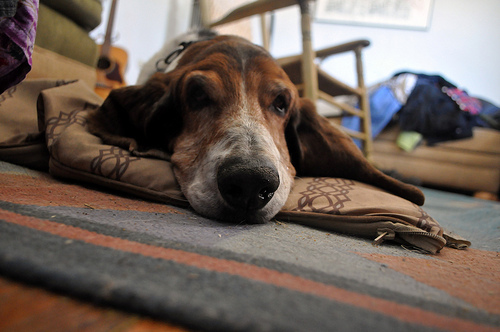

In [8]:
img_number = 7
img = PILImage.create(files[img_number])
img

# Cats-vs-Dogs

Als einfachstes Modell trainieren wir einen Cats-vs-Dogs Classifier. D.h. das Modell wird trainiert um zwischen Hunden und Katzen zu unterscheiden. Dazu machen wir uns zu Nutze, dass in diesem Datensatz, die Katzenbilder mit einen Großbuchstaben beginnen (Egyptian_Mau_167.jpg) und die Hundebilder mit Kleinbuchstaben (shiba_inu_136.jpg).

In [10]:
def label_func(f): return 'Cat' if f[0].isupper() else 'Dog'

Damit wir unser Modell mit den Bildern "füttern" können, müssen wir einen Dataloader erstellen. Der Dataloader ist dafür zuständig, die Bilder zu laden und mit den passenden Labels (bzw. Klassen - in diesem Beispiel Cat / Dog zu versehen). Deep Learning Modelle verarbeiten die Daten in Batches. D. h. die Bilder werden nicht einzeln, sondern in "Batches" von 64  Bildern (die Standard Batch-Size) zusammengefasst und verarbeitet. Da sie nicht mit Daten unterschiedlicher Größe oder Form arbieten können, müssen alle Bilder auf dieselbe Größe zugeschnitten werden (hier 224 x 224 Pixel).

In [11]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

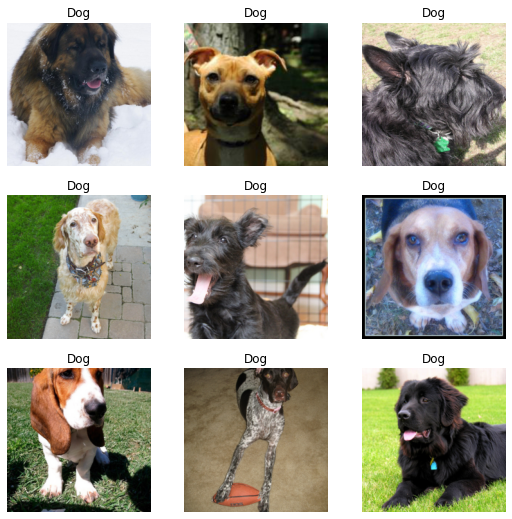

In [12]:
dls.show_batch()

Mit `dls.one_batch()` laden wir einen Batch und zeigen uns die `shape` an:

**(Batch-Size, Farb-Kanäle (rot, grün, blau), Höhe, Breite)**

In [13]:
batch = dls.one_batch()
batch[0].shape

torch.Size([64, 3, 224, 224])

Der Dataloader hat im Hintergrund die Bilder in einen `Tensor` umgewandelt. Man kann vereinfacht sagen, dass alle Input-Daten, die ein Deep Learning Modell verarbeiten soll, in einen Tensor umgewandelt werden müssen. Ein Tensor ist ein mehrdimensionales Array, das 32-Bit Float Zahlen enthält - eine Datenstruktur.

Unsere Bilder sind `TensorImage`s:

In [14]:
batch[0]

TensorImage([[[[0.7176, 0.6392, 0.5725,  ..., 0.1176, 0.1137, 0.1137],
          [0.7608, 0.7333, 0.6627,  ..., 0.1098, 0.1059, 0.1059],
          [0.7686, 0.7608, 0.7529,  ..., 0.1059, 0.1059, 0.1059],
          ...,
          [0.5333, 0.5922, 0.6235,  ..., 0.8314, 0.8392, 0.8471],
          [0.5882, 0.6118, 0.5961,  ..., 0.8314, 0.8431, 0.8471],
          [0.5961, 0.6275, 0.6157,  ..., 0.8353, 0.8353, 0.8275]],

         [[0.8118, 0.7333, 0.6667,  ..., 0.1216, 0.1216, 0.1255],
          [0.8549, 0.8275, 0.7608,  ..., 0.1137, 0.1137, 0.1176],
          [0.8588, 0.8549, 0.8510,  ..., 0.1098, 0.1137, 0.1137],
          ...,
          [0.5882, 0.6431, 0.6706,  ..., 0.9882, 0.9922, 0.9922],
          [0.6353, 0.6588, 0.6392,  ..., 0.9882, 0.9961, 0.9882],
          [0.6431, 0.6745, 0.6549,  ..., 0.9882, 0.9882, 0.9765]],

         [[0.9529, 0.8902, 0.8275,  ..., 0.1922, 0.1765, 0.1647],
          [0.9922, 0.9765, 0.9137,  ..., 0.1843, 0.1686, 0.1569],
          [0.9922, 0.9961, 0.9922,  .

Unsere Kategorien (Cat / Dog) wurden auch durch den Dataloader in Tensoren (`TensorCategory`) umgewandelt:

In [15]:
batch[1]

TensorCategory([0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')

# Modell trainieren

Wir trainieren ein Resnet34-Modell - genauer gesagt nehmen wir ein "Pretrained"-Modell und Fine-tunen es. Es handelt sich hierbei um ein Convolutional Neural Network (kurz: CNN) - ein künstliches neuronales Netz. Wie gut unser Modell funktioniert, können wir an der Genauigkeit (accuracy) ablesen. Die accuracy zeigt uns, welchen Prozentsatz der Bilder korrekt kalssifiziert wurden.

Ein Learner ist ein fast.ai Objekt, das unsere Daten und das Modell fürs Training kombiniert.

In [16]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.152784,0.030596,0.990528,00:54


epoch,train_loss,valid_loss,accuracy,time
0,0.048346,0.031216,0.991881,00:35


Die erste Zeile zeigt die Ergebnisse des Pretrained-Modells angepasst für unser Problem. In der zweiten Zeile stehen die Ergebnisse nach dem Fine-Tuning.

# Ergebnisse anzeigen

`learn.show_results()` zeigt Beispielbilder und deren Klassifizierung an (rot bedeutet, dass das Modell das Bild falsch klassifiziert hat).

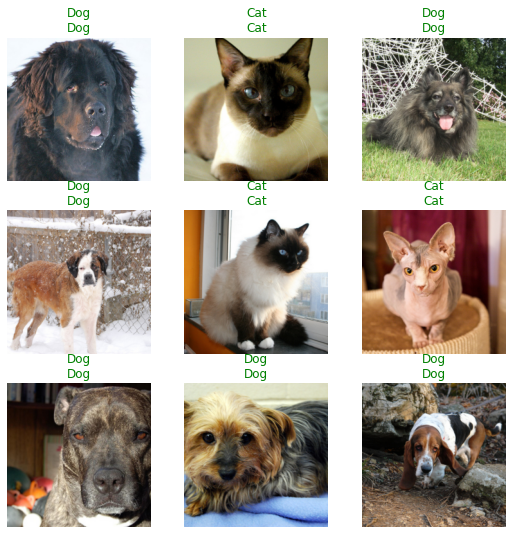

In [17]:
learn.show_results()

Mit `learn.predict()` können wir ein einzelnes Bild von unserem Modell klassifizieren lassen.

**(vorhergesagte Kategorie, Index der vorhergesagten Kategorie, Tensor der Möglichkeiten aller Kategorien (Cat/Dog))**

In [20]:
img_to_predict = files[9]
learn.predict(img_to_predict)

('Dog', TensorBase(1), TensorBase([6.1399e-06, 9.9999e-01]))

Liegt das Modell richtig? Die folgende Zelle zeigt das Bild an:

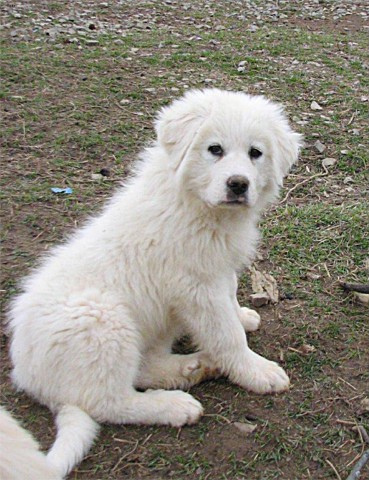

In [21]:
PILImage.create(img_to_predict)